## Keplerian Orbits

In [2]:
# local install includes
local_venv = '/udd0/litterbox/venv/bin/activate_this.py'
execfile(local_venv, dict(__file__=local_venv))

%matplotlib inline
import numpy
import pylab

https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-11

Let the two bodies involved have masses $m_1$, $m_2m_1$, $m_2$.   
Start with Newton's second law $F=ma$, where $a$ is acceleration.   
The gravitational force on body 2 from body 1 is given by $F_{21}=\frac{Gm_1m_2}{|r_{21}|^3}\times r_{21}$, where $r_{21}$ is the relative position vector for the two bodies in question.   
The force on body 1 from body two is of course $F_{12}=−F_{21}$ since $r_{12}=−r_{21}$.   

If we denote the positions by $(x_1,y_1)$ and $(x_2,y_2)$, then $r_{21}=\frac{x_1−x_2}{y_1−y_2}$ and $|r|=\sqrt{(x_1−x_2)^2+(y_1−y_2)^2}$

Then Newton's law $a=F/m$ becomes   
$x″_1(t)=\frac{Gm_2(x_2−x_1)}{|r|^3}$   
$y″_1(t)=\frac{Gm_2(y_2−y_1)}{|r|^3}$   
$x″_2(t)=\frac{Gm_1(x_1−x_2)}{|r|^3}$   
$y″_2(t)=\frac{Gm_1(y_1−y2)}{|r|^3}$

Together with the initial positions and velocities, this system of ordinary differential
equations (ODEs) comprises an initial value problem. The usual approach is to write this
as a first-order system of 8 equations and apply a Runge-Kutta or multistep method to
solve them.

If you apply something simple like forward Euler or backward Euler, you will see the
Earth spiral out to infinity or in toward the sun, respectively, but that is an effect of
the numerical errors. If you use a more accurate method, like the classical
4th-order Runge-Kutta method, you'll find that it stays close to a true orbit for a while
but still eventually goes off to infinity. The right approach is to use a symplectic method,
which will keep the Earth in the correct orbit -- although its phase will still be off due
to numerical errors.

For the 2-body problem it's possible to derive a simpler system by basing your coordinate
system around the center of mass. But I think the formulation above is clearer if this is
new to you.

## Runge Kutta

In [3]:
force = lambda R, mu: (-mu/numpy.linalg.norm(R)**3.)*R

def RK4(dt, X, mu=None):
    # dt - step size
    # X - position and velocity initial value vector
    # mu - gravitational parameter

    pos = X[:3]
    vel = X[-3:]
    if mu is None: mu=numpy.linalg.norm(pos)*(numpy.linalg.norm(vel)**2)

    k1p = dt * vel
    k1v = dt * force(pos, mu)

    k2p = dt * (vel + 0.5*k1v)
    k2v = dt * force(pos + 0.5*k1p, mu)

    k3p = dt * (vel + 0.5*k2v)
    k3v = dt * force(pos + 0.5*k2p, mu)

    k4p = dt * (vel+ k3v)
    k4v = dt * force(pos + k3p, mu)

    pos = pos + (k1p + 2.*k2p + 2.*k3p + k4p) / 6.
    vel = vel + (k1v + 2.*k2v + 2.*k3v + k4v) / 6.

    return numpy.hstack((pos,vel))    

### Galactic orbit

In [4]:
# Constants
Solar_mass = 1.98892e30 # kg
pc = 3.09e16 # m
M = 1e11 # solar mass
# The gravitational constant G
# G = 6.67428e-11
G = 0.004301 # pc (km/s)^2 (solar mass)^-1
muGM = G*M*1e-3 # kpc (km/s)^2
print muGM

# Sun's velocity around the Galactic center
V0 = 217.4 # km/s
# Distance of the Sun to the Galactic center
R0 = 8.3 # kpc

430100.0


In [5]:
# # Solar orbit
# R0 = -1.0*numpy.array([8.0, 0., 0.]) # kpc
# V0 =  numpy.array([0., 217.4, 0.]) # km/s
# Stellar orbit
R0 = numpy.array([7.8, 0.1, -1.3]) # kpc
V0 = numpy.array([-1.8, 178.5, -25.9]) # km/s
# Assume a near circular orbit
muRV = numpy.linalg.norm(R0)*(numpy.linalg.norm(V0)**2)
print muRV

257304.3344724931


In [6]:
# Time
end=1e9 # 1 Gyr
h=0.01e6 # 0.01 Myr
t=numpy.arange(0, end+h, h)/1e6 # Myr
seconds_per_year = 365.25*24*60**2
yr = seconds_per_year/3.09e16 # kpc / km/s
h = h*yr # kpc / km/s

In [7]:
# Orbit integration
GM_X2body_RK = numpy.hstack([R0, V0]).reshape((6,1))
RV_X2body_RK = numpy.hstack([R0, V0]).reshape((6,1))
Decay_X2body_RK = numpy.hstack([R0, V0]).reshape((6,1))
for idx in range(1,len(t)):
    RK4step = RK4(h, GM_X2body_RK[:,-1], muGM).reshape((6,1))
    GM_X2body_RK = numpy.hstack((GM_X2body_RK, RK4step))
    
    RK4step = RK4(h, RV_X2body_RK[:,-1], muRV).reshape((6,1))
    RV_X2body_RK = numpy.hstack((RV_X2body_RK, RK4step))
    
    RK4step = RK4(h, Decay_X2body_RK[:,-1]).reshape((6,1))
    Decay_X2body_RK = numpy.hstack((Decay_X2body_RK, RK4step))  

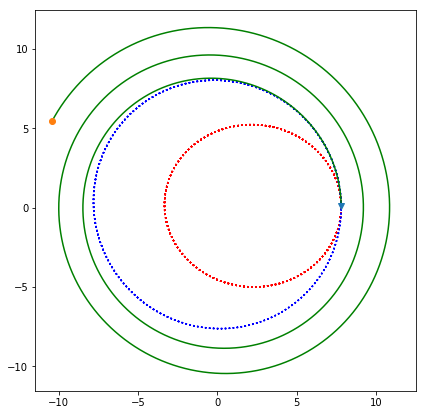

In [8]:
pylab.figure(figsize=(15, 7));
pylab.plot(GM_X2body_RK[0,:], GM_X2body_RK[1,:],'r:');
pylab.plot(RV_X2body_RK[0,:], RV_X2body_RK[1,:],'b:');
pylab.plot(Decay_X2body_RK[0,:], Decay_X2body_RK[1,:],'g');
pylab.plot(Decay_X2body_RK[0,0], Decay_X2body_RK[1,0], 'v', label='Now')
pylab.plot(Decay_X2body_RK[0,-1], Decay_X2body_RK[1,-1], 'o', label='1 GYr ago')

pylab.axis('square');

Text(0.5,0,u't (sec)')

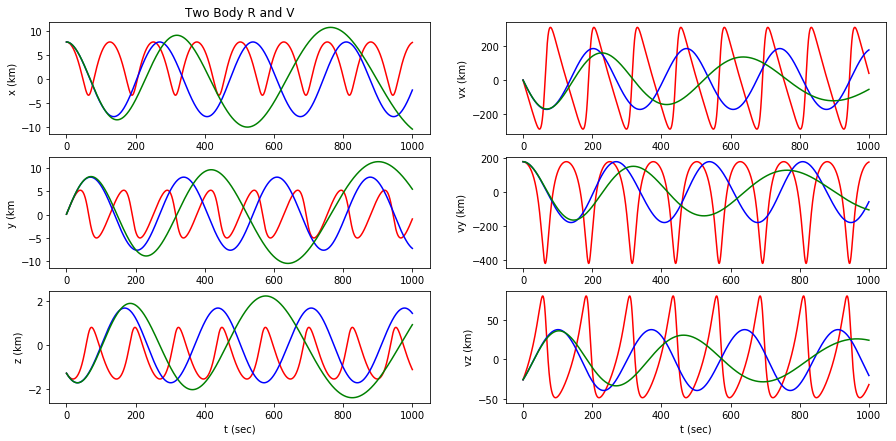

In [9]:
pylab.figure(figsize=(15, 7))
pylab.subplot(321)
pylab.plot(t, GM_X2body_RK[0,:],'r-')
pylab.plot(t, RV_X2body_RK[0,:],'b-')
pylab.plot(t, Decay_X2body_RK[0,:],'g-')
pylab.ylabel('x (km)')
pylab.title('Two Body R and V')

pylab.subplot(323)
pylab.plot(t, GM_X2body_RK[1,:],'r-')
pylab.plot(t, RV_X2body_RK[1,:],'b-')
pylab.plot(t, Decay_X2body_RK[1,:],'g-')
pylab.ylabel('y (km')

pylab.subplot(325)
pylab.plot(t, GM_X2body_RK[2,:],'r-')
pylab.plot(t, RV_X2body_RK[2,:],'b-')
pylab.plot(t, Decay_X2body_RK[2,:],'g-')
pylab.ylabel('z (km)')
pylab.xlabel('t (sec)')

pylab.subplot(322)
pylab.plot(t, GM_X2body_RK[3,:],'r-')
pylab.plot(t, RV_X2body_RK[3,:],'b-')
pylab.plot(t, Decay_X2body_RK[3,:],'g-')
pylab.ylabel('vx (km)')

pylab.subplot(324)
pylab.plot(t, GM_X2body_RK[4,:],'r-')
pylab.plot(t, RV_X2body_RK[4,:],'b-')
pylab.plot(t, Decay_X2body_RK[4,:],'g-')
pylab.ylabel('vy (km)')

pylab.subplot(326)
pylab.plot(t, GM_X2body_RK[5,:],'r-')
pylab.plot(t, RV_X2body_RK[5,:],'b-')
pylab.plot(t, Decay_X2body_RK[5,:],'g-')
pylab.ylabel('vz (km)')
pylab.xlabel('t (sec)')